# Amazon

Description of columns in the file:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)


### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import re
import string
import torch


### Import Dataset

In [2]:
reviews = pd.read_csv('Musical_instruments_reviews.csv')
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


### Preprocessing

In [4]:
# Removing columns not required for sentiment analysis
reviews.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)
reviews.head()


,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [5]:
reviews['text'] = reviews['reviewText'] + ' ' + reviews['summary']
reviews.drop(['reviewText', 'summary'], axis=1, inplace=True)
reviews.head()


,overall,text
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...
2,5.0,The primary job of this device is to block the...
3,5.0,Nice windscreen protects my MXL mic and preven...
4,5.0,This pop filter is great. It looks and perform...


In [6]:
# Finding Null Values
reviews.isnull().sum()

overall    0
text       7
dtype: int64

In [7]:
reviews['text'] = reviews['text'].fillna('review_missing') # filling the missing review content with missing_review 
reviews = reviews.dropna()  # droping reviews without reviewerName
reviews.isnull().sum()

overall    0
text       0
dtype: int64

In [8]:
# Here assuming the 3 rating is neutral and above and below is postive and negative sentiment respectively
reviews['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [9]:
# text preprocessing
import nltk
# nltk.download_gui()


In [10]:
stopwords = nltk.corpus.stopwords.words("english")


In [11]:
def text_clean(txt):
    txt = str(txt).lower()
    txt = re.sub('\[.*?\]', '', txt)
    txt = re.sub('https?://\S+|www\.\S+', '', txt)
    txt = re.sub('<.*?>+', '', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = re.sub('\n', '', txt)
    txt = re.sub('\w*\d\w*', '', txt)
    return txt


In [12]:
reviews['text'] = reviews['text'].apply(lambda x: text_clean(x))
reviews.head()


,overall,text
0,5.0,not much to write about here but it does exact...
1,5.0,the product does exactly as it should and is q...
2,5.0,the primary job of this device is to block the...
3,5.0,nice windscreen protects my mxl mic and preven...
4,5.0,this pop filter is great it looks and performs...


In [13]:
def overall_to_sentiment_class(x):
    if x == 4.0 or x == 5.0:
        sentiment = "positive"
    elif x == 3.0:
        sentiment = "neutral"
    elif x == 1.0 or x == 2.0:
        sentiment = "negative"
    return sentiment


In [14]:
reviews['sentiment_class'] = reviews['overall'].apply(lambda x: overall_to_sentiment_class(x))
reviews.drop(['overall'], axis=1, inplace=True)
reviews.head()


,text,sentiment_class
0,not much to write about here but it does exact...,positive
1,the product does exactly as it should and is q...,positive
2,the primary job of this device is to block the...,positive
3,nice windscreen protects my mxl mic and preven...,positive
4,this pop filter is great it looks and performs...,positive


<BarContainer object of 3 artists>

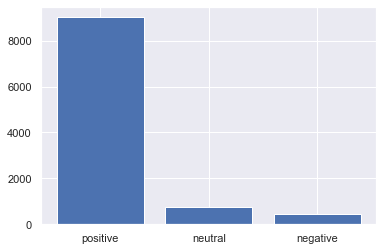

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
list_classes_value = reviews['sentiment_class'].value_counts().to_list()
classes_name = reviews['sentiment_class'].unique()
plt.bar(classes_name,list_classes_value)
# addlabels(x, y)


In [16]:
reviews['sentiment_class'].value_counts()


positive    9022
neutral      772
negative     467
Name: sentiment_class, dtype: int64

In [17]:
import plotly.express as px
# px.bar(classes_name, list_classes_value)


In [18]:
# sentiment analysis
def stopwords_removal(txt):
    txt = ' '.join([x for x in txt.split() if x.lower() not in stopwords])
    return txt

In [19]:
reviews['text'] = reviews['text'].apply(lambda x: stopwords_removal(x))


In [20]:
reviews.head()

,text,sentiment_class
0,much write exactly supposed filters pop sounds...,positive
1,product exactly quite affordablei realized dou...,positive
2,primary job device block breath would otherwis...,positive
3,nice windscreen protects mxl mic prevents pops...,positive
4,pop filter great looks performs like studio fi...,positive


In [21]:
df_model = reviews.copy()
df_model.head()
df_model.drop(['sentiment_class'], axis=1, inplace=True)


In [22]:
# encoding sentiment classes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
reviews['sentiment_class'] = encoder.fit_transform(reviews['sentiment_class'])

In [23]:
reviews['sentiment_class'].value_counts()

2    9022
1     772
0     467
Name: sentiment_class, dtype: int64

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
# TF-IDF feature matrix
X = tfidf_vectorizer.fit_transform(reviews['text'])
y = reviews['sentiment_class']


In [26]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_data, y_data = smote.fit_resample(X, y)

Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


In [27]:
#model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=0)


In [28]:
#creating the objects
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


logreg_model = LogisticRegression(random_state=0)
dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
svc_model = SVC()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'KNN', 3: 'SVC'}
cv_models = [logreg_model, dt_model, knn_model, svc_model]


for i, model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i], cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()))


Logistic Regression Test Accuracy: 0.881103196159825
Decision Tree Test Accuracy: 0.8154164080546492
KNN Test Accuracy: 0.8377344828044363
SVC Test Accuracy: 0.880518305934695


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-4, 4, 50),
              'penalty': ['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(X_train, y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:", best_model.score(X_test, y_test))


f:\projects\python\privateprojects\dsandml\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.33563229        nan 0.33597713        nan 0.33834179
        nan 0.34558354        nan 0.36937781        nan 0.43425772
        nan 0.53928752        nan 0.57761459        nan 0.60613818
        nan 0.6374203         nan 0.67229895        nan 0.69796539
        nan 0.71840983        nan 0.73378029        nan 0.74708133
        nan 0.75703267        nan 0.76752571        nan 0.77604819
        nan 0.78654138        nan 0.7991528         nan 0.81225681
        nan 0.82531154        nan 0.83935163        nan 0.85211077
        nan 0.86344158        nan 0.87447647        nan 0.88196442
        nan 0.88841794        nan 0.89511785        nan 0.90014293
        nan 0.90304931        nan 0.90556173        nan 0.90738433
        nan 0.90999538        nan 0.91300029        nan 0.91452738
        nan 0.91812377        nan 0

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9528594650509827


f:\projects\python\privateprojects\dsandml\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
final_model = LogisticRegression(C=10000.0, random_state=0)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print('Accuracy of classifier on test set: {:.2f}'.format(final_model.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.95


f:\projects\python\privateprojects\dsandml\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2322    0    4]
 [  58 2174    0]
 [ 107  150 1952]]


<AxesSubplot:>

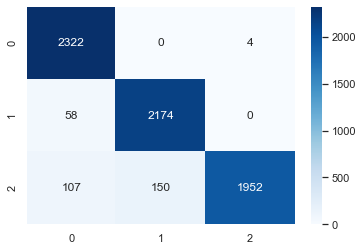

In [41]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
